In [1]:
import pandas as pd
%matplotlib inline

In [2]:
df911 = pd.read_csv('raw/911_Police_Calls_for_Service.csv', sep=';')

In [3]:
df911.head()

,recordId,callDateTime,priority,district,description,callNumber,incidentLocation,location
0,1423624,05/04/2016 09:58:00 PM,High,ND,SILENT ALARM,P161253035,400 WINSTON AV,"400 WINSTON AV\nBALTIMORE, MD\n(39.349792, -76..."
1,1402097,04/27/2016 03:57:00 PM,Medium,SW,911/HANGUP,P161182081,1400 BRADDISH AV,"1400 BRADDISH AV\nBALTIMORE, MD\n(39.303941, -..."
2,1420176,05/03/2016 06:40:00 PM,Medium,ED,DISORDERLY,P161242705,200 E NORTH AV,"200 E NORTH AV\nBALTIMORE, MD\n(39.311294, -76..."
3,1423653,05/04/2016 10:10:00 PM,Medium,NE,911/NO VOICE,P161253068,2500-1 HARFORD RD,"2500 1 HARFORD RD\nBALTIMORE, MD\n(39.316763, ..."
4,1417949,05/03/2016 12:29:00 AM,Non-Emergency,SD,Private Tow,P161240063,100 W PATAPSCO AV,"100 W PATAPSCO AV\nBALTIMORE, MD\n(39.239215, ..."


In [4]:
df911.shape

(3242420, 8)

# preprocessing

In [5]:
# fillna
df911.priority.fillna('NaN', inplace=True)
df911.description.fillna('NaN', inplace=True)  # no description is na
df911.location.fillna('NaN', inplace=True)

In [6]:
def extract_coords(x):
    x=x.strip()
    if x is None:
        return None
    try:
        coords = eval(x.split('\n')[-1])
    except (NameError, SyntaxError):
        return None
    if isinstance(coords, tuple):
        return coords
    return None

In [7]:
# extract location
df911['coords'] = df911.location.apply(extract_coords)

In [8]:
df911['Latitude'] = df911.coords.apply(lambda x: x[0] if x is not None else None)
df911['Longitude'] = df911.coords.apply(lambda x: x[1] if x is not None else None)

In [9]:
df911['Date'] = df911.callDateTime.apply(lambda x: x[:10])
df911['Date'] = pd.to_datetime(df911['Date'], format='%m/%d/%Y')

In [11]:
df911['DateTime'] = pd.to_datetime(df911['callDateTime'], format='%m/%d/%Y %I:%M:%S %p')

In [18]:
df911.duplicated().sum()

0

# categorical variable counts

In [10]:
priority = df911.priority.value_counts().to_frame()
priority.priority.sum()

3242420

In [11]:
priority_types = ['Low', 'Medium', 'High', 'Non-Emergency', 'Emergency', 'Out of Service']

### raw description count

In [ ]:
description = df911.description.value_counts().to_frame()

In [15]:
description['percentage'] = description.description/description.description.sum()

In [16]:
# description.to_csv('tmp-911-description.csv')
description.shape

(8810, 2)

### mapped to category

In [12]:
from manual.category_mapping import CatMapping

In [13]:
cmap = CatMapping('manual/911_categories.csv')

In [14]:
df911[cmap.to_col] = cmap.apply_mapping(df911)

In [20]:
# description_types = ['DISORDERLY', 'COMMON ASSAULT', 'NARCOTICSOutside', 'SILENT ALARM', 'FAMILY DISTURB', 'BURGLARY']
description_types = list(cmap.get_categories())

# Time series

In [21]:
min_date = df911['date'].min()
max_date = df911['date'].max()
temporal_df = pd.DataFrame(index=pd.date_range(min_date, max_date))
date_col = 'date'

In [22]:
temporal_df = temporal_df.join(df911.groupby(date_col).agg({date_col: 'count'}).rename(columns={date_col: 'ALL'}))

In [20]:
col = 'priority'
for t in priority_types:
    temporal_df = temporal_df.join(
        df911[df911[col]==t].groupby(date_col).agg({date_col: 'count'}).rename(columns={date_col:col+'-'+t}))

In [23]:
col = 'Category'
for t in description_types:
    temporal_df = temporal_df.join(
        df911[df911[col]==t].groupby(date_col).agg({date_col: 'count'}).rename(columns={date_col:col+'-'+t}))

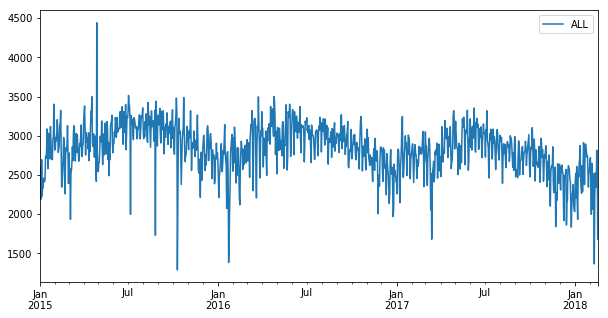

In [24]:
temporal_df[['ALL']].plot(figsize=(10,5))

time series


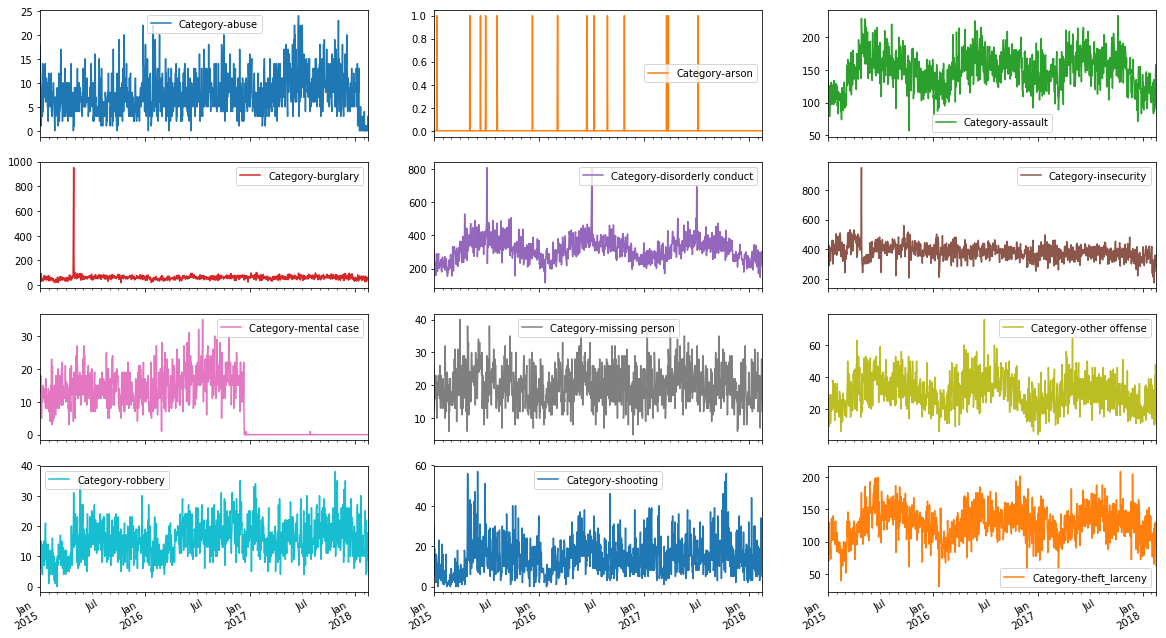

In [25]:
temporal_df.drop('ALL', axis=1).fillna(0).plot(subplots=True, layout=(5,3), figsize=(20,15))
print('time series')

# grid

In [24]:
from shapely.geometry import Point, box
import geopandas as gp
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot

In [25]:

def grid_line(mini, maxi, ngrid=10):
    delta = (maxi - mini) / ngrid
    return [(mini + i * delta, mini + (i + 1) * delta) for i in range(ngrid)]


def grid_area(w, s, e, n, ngrid=10):
    """
    grid area into ngrid^2 grids
    :param w, s, e, n,: the w, s, e, n (min_lon, min_lat, max_lon, max_lat) of the bound box
    :param ngrid: divide area into ngrid^2 grids
    :return: list of grid represented by bound box with s,w,n,e
    """
    grid_lat = grid_line(s, n, ngrid)
    grid_lon = grid_line(w, e, ngrid)
    grids = []
    for i in range(ngrid):
        for j in range(ngrid):
            si, ni = grid_lat[i]
            wj, ej = grid_lon[j]
            grids.append((wj, si, ej, ni))
    return grids

In [26]:
cityline = gp.read_file('raw/Baltcity_Line/baltcity_line.shp')
cityline.to_crs(epsg=3559, inplace=True)

In [27]:
gpdf_911 = df911[['Longitude', 'Latitude', 'priority', 'description']]
gpdf_911 = gpdf_911[~gpdf_911.Longitude.isnull()]
gpdf_911['geometry'] = gpdf_911.apply(lambda x: Point(x.Longitude, x.Latitude), axis=1)
gpdf_911 = gp.GeoDataFrame(gpdf_911.drop(['Longitude', 'Latitude'], axis=1), crs={'init': 'epsg:4326'})
gpdf_911.to_crs(cityline.crs, inplace=True)

In [28]:
line = cityline.geometry[0]
grids = grid_area(*line.bounds, ngrid=50)
wsen_poly = [box(*grid) for grid in grids]
wsen_poly = gp.GeoDataFrame(wsen_poly,columns=['geometry'], crs=cityline.crs)

distance between centroids of grids: 314.5389899998554


(-314.5389899999718, -388.1525280000933)

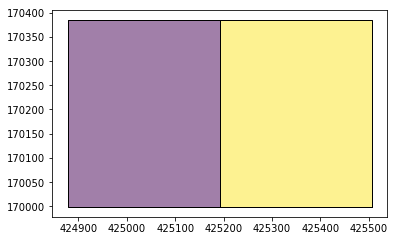

In [29]:
import math
[(a,b)] = wsen_poly.geometry[0].centroid.coords
[(c,d)] = wsen_poly.geometry[1].centroid.coords
print('distance between centroids of grids:', math.sqrt((a-c)**2+(b-d)**2))

wsen_poly[:2].plot()

a,b,c,d = wsen_poly.geometry[0].bounds
a-c, b-d

In [30]:
joined = gp.sjoin(gpdf_911, wsen_poly)

In [31]:
wsen_poly = wsen_poly.join(joined.groupby('index_right').agg({'description': 'count'}).rename(columns={'description':'ALL'}), how='inner')

In [32]:
df911.shape[0], gpdf_911.shape[0], joined.shape[0], wsen_poly.ALL.sum()

(3242420, 2457409, 2353484, 2353484)

In [33]:
col = 'description'
for t in description_types:
    wsen_poly = wsen_poly.join(
        joined[joined[col]==t].groupby('index_right').agg({col: 'count'}).rename(columns={col: col+'-'+t}))

In [34]:
col = 'priority'
for t in priority_types:
    wsen_poly = wsen_poly.join(
        joined[joined[col]==t].groupby('index_right').agg({col: 'count'}).rename(columns={col: col+'-'+t}))

In [35]:
wsen_poly.fillna(0, inplace=True)

In [36]:

cmap = LinearSegmentedColormap.from_list('mycmap', [(0, '#ffffcc'), (1, '#800026')])

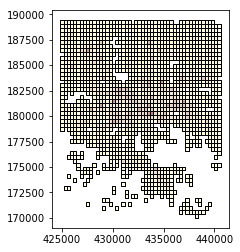

In [37]:
wsen_poly.plot(column='ALL', cmap=cmap)

In [38]:
wsen_poly

,geometry,ALL,description-DISORDERLY,description-COMMON ASSAULT,description-NARCOTICSOutside,description-SILENT ALARM,description-FAMILY DISTURB,description-BURGLARY,priority-Low,priority-Medium,priority-High,priority-Non-Emergency,priority-Emergency,priority-Out of Service
42,"POLYGON ((438402.9387764572 169997.5488773746,...",213,18.0,3.0,1.0,12.0,2.0,0.0,63.0,54.0,28.0,68.0,0.0,0.0
87,"POLYGON ((436830.2438264574 170385.7014053747,...",2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
89,"POLYGON ((437459.3218064573 170385.7014053747,...",9,6.0,0.0,0.0,0.0,1.0,0.0,1.0,7.0,1.0,0.0,0.0,0.0
90,"POLYGON ((437773.8607964573 170385.7014053747,...",188,17.0,5.0,0.0,23.0,1.0,9.0,61.0,65.0,30.0,32.0,0.0,0.0
91,"POLYGON ((438088.3997864572 170385.7014053747,...",9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0
92,"POLYGON ((438402.9387764572 170385.7014053747,...",157,6.0,0.0,0.0,3.0,0.0,1.0,85.0,22.0,10.0,40.0,0.0,0.0
93,"POLYGON ((438717.4777664572 170385.7014053747,...",40,2.0,0.0,0.0,19.0,0.0,0.0,5.0,5.0,28.0,2.0,0.0,0.0
94,"POLYGON ((439032.0167564572 170385.7014053747,...",16,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,9.0,2.0,0.0,0.0
113,"POLYGON ((429281.308066458 170773.8539333747, ...",1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
117,"POLYGON ((430539.4640264579 170773.8539333747,...",1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


0 0
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0
4 1
4 2


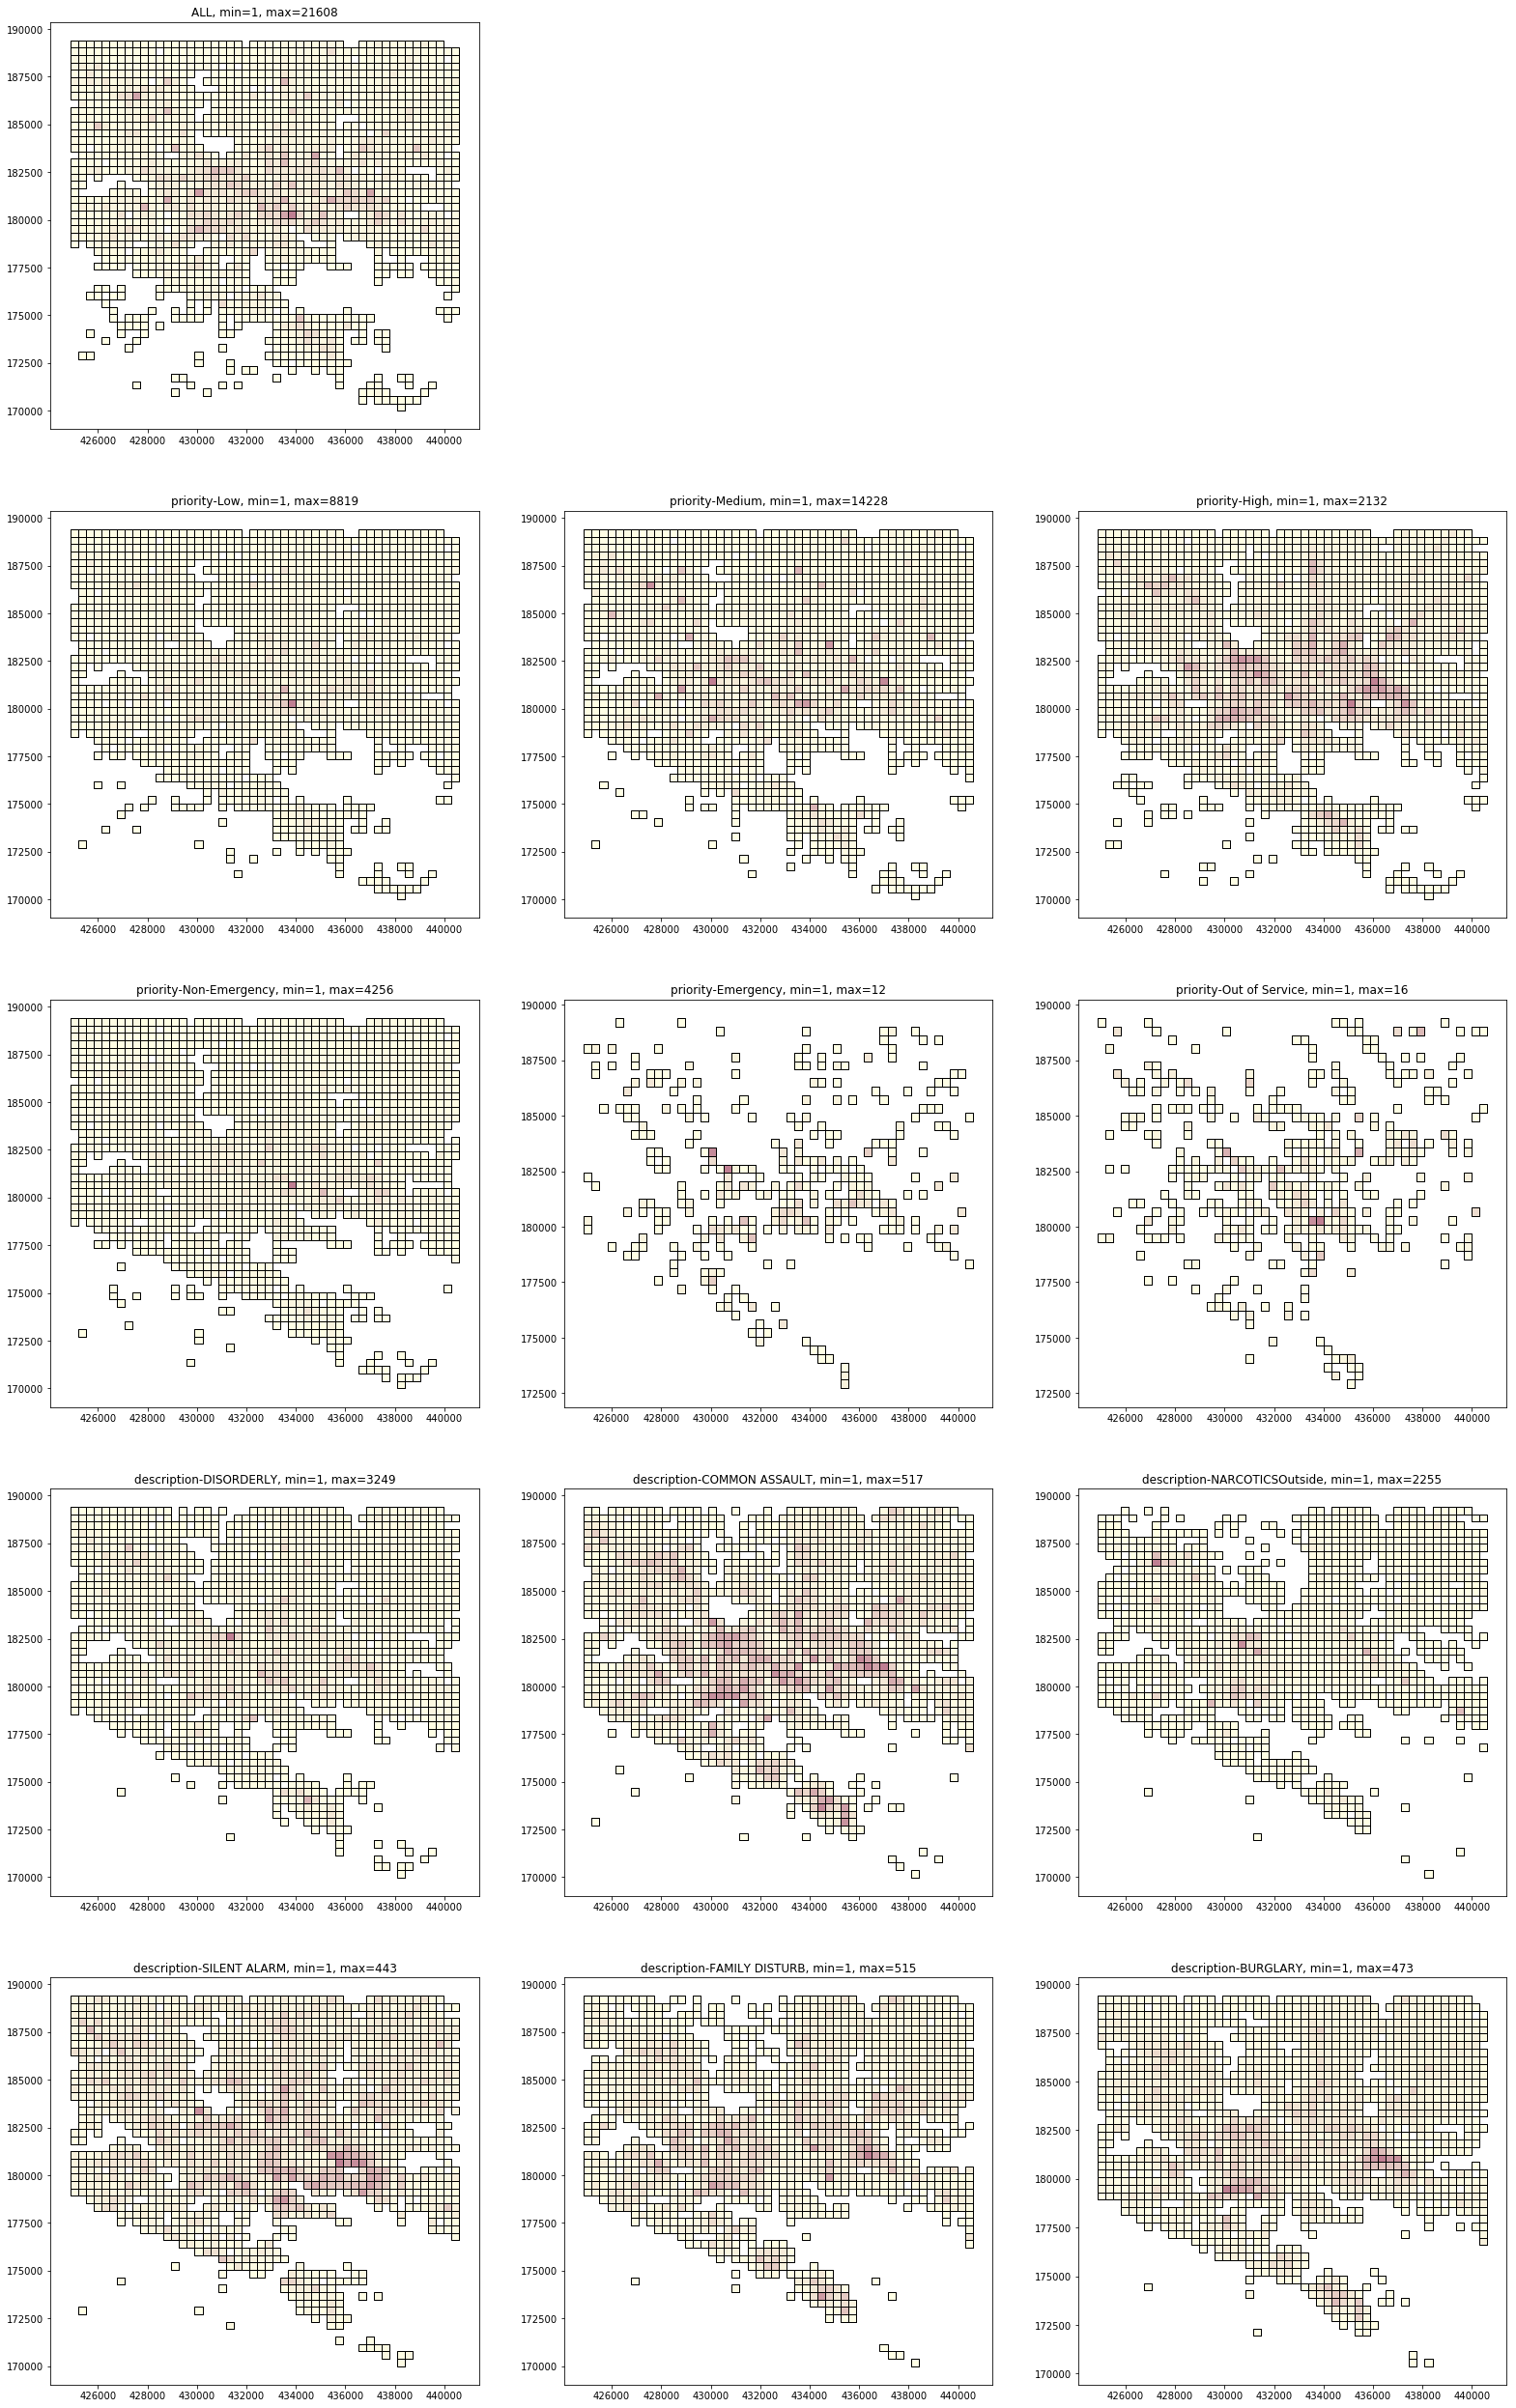

In [39]:

# fig, axes = pyplot.subplots(ncols=3, nrows=2, sharex=True, sharey=True, figsize=(27, 18))
fig =pyplot.figure(figsize=(27,45))
for i, t in enumerate(['ALL'] + ['priority-'+t for t in priority_types]+['description-'+t for t in description_types]):
#     ax = axes[int(i/3)][i%3]
    if t!='ALL':
        i+=2
    print(int(i/3), i%3)
    ax = pyplot.subplot2grid((5,3), (int(i/3), i%3))
    mini, maxi = wsen_poly[wsen_poly[t]>0][t].min(), wsen_poly[t].max()
    ax.set_title('%s, min=%d, max=%d' % (t, mini, maxi))
    wsen_poly[wsen_poly[t]>0].plot(column=t, cmap=cmap, ax=ax, figsize=(9,9))
    

# Moran I

In [40]:
import pysal

In [41]:
wsen_poly.index = range(wsen_poly.shape[0])

In [42]:
# There are different kinds of distance weights
# e.g. K nearest neighbours
ks = [1,2,3,4,5,6,7,8, 9, 10]
ws_knn = {k: pysal.weights.KNN.from_dataframe(wsen_poly[['geometry']], k=k) for k in ks}

# e.g. distanct band
# There are 2 kinds of distant band weight, binary or non-binary. I don't know the exact difference between them. 
# with correct CRS, the unit of the following dbs is meter
dbs = [315, 650, 980, 1300]
ws_db_notbinary = {db: pysal.weights.DistanceBand.from_dataframe(wsen_poly[['geometry']], threshold=db, binary=False, silent=True) for db in dbs}
ws_db_binary = {db: pysal.weights.DistanceBand.from_dataframe(wsen_poly[['geometry']], threshold=db, binary=True, silent=True) for db in dbs}

D:\ProgramFiles\Anaconda3\lib\site-packages\scipy\sparse\data.py:103: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In [43]:
# for KNN, every shape has k neighbors
# but for distance band, there are some islands which has no neighbors
# I choose 150 meter binary distance band weight in the cycling safety project considering the percentage of islands.
islands = [ws_db_binary[db].islands.__len__() for db in dbs]
pd.DataFrame(list(zip(dbs, islands)), columns=['band', 'num_islands']).set_index('band').T

band,315,650,980,1300
num_islands,65,7,1,1


In [44]:
def compute_moran_i(ws, param_list, x, pname):
    res = []

    for i, cname in enumerate(x):
        print('i=', i, cname)
            
        data = x[cname]
        for p in param_list:
            w = ws[p]
            mi = pysal.Moran(data, w, two_tailed=True, permutations=999)
            res.append({
                'column':cname, 
                pname:p,
                'I': mi.I, 
                'EI': mi.EI, 
                'p_norm': mi.p_norm * 2,
                'p_rand': mi.p_rand * 2,
                'z_norm': mi.z_norm,
                'z_rand': mi.z_rand,
            })
    print('done computing', pname)
    df = pd.DataFrame(res)
    return df[['column', pname, 'I', 'EI', 'p_norm', 'p_rand', 'z_norm', 'z_rand']]

In [45]:
# the function loop over each column of the features X. 
# It took quite a while for me to compute 200 features, maybe 1 hour or 2
# PySAL provides a function to compute moran I directly from a dataframe
# I don't know if that function would be faster

df_db_binary = compute_moran_i(ws_db_binary, dbs, wsen_poly.drop('geometry', axis=1), 'db_b')

i= 0 ALL
i= 1 description-DISORDERLY
i= 2 description-COMMON ASSAULT
i= 3 description-NARCOTICSOutside
i= 4 description-SILENT ALARM
i= 5 description-FAMILY DISTURB
i= 6 description-BURGLARY
i= 7 priority-Low
i= 8 priority-Medium
i= 9 priority-High
i= 10 priority-Non-Emergency
i= 11 priority-Emergency
i= 12 priority-Out of Service
done computing db_b


In [51]:
df_db_binary.groupby(['column', 'db_b']).agg(lambda x: x)

I        EI        p_norm  \
column                       db_b                                     
ALL                          315   0.432357 -0.000602  0.000000e+00   
                             650   0.365954 -0.000602  0.000000e+00   
                             980   0.322862 -0.000602  0.000000e+00   
                             1300  0.284414 -0.000602  0.000000e+00   
description-BURGLARY         315   0.659096 -0.000602  0.000000e+00   
                             650   0.551882 -0.000602  0.000000e+00   
                             980   0.439477 -0.000602  0.000000e+00   
                             1300  0.342352 -0.000602  0.000000e+00   
description-COMMON ASSAULT   315   0.565971 -0.000602  0.000000e+00   
                             650   0.485438 -0.000602  0.000000e+00   
                             980   0.406402 -0.000602  0.000000e+00   
                             1300  0.338832 -0.000602  0.000000e+00   
description-DISORDERLY       315   0.443737 -0.000602  0.000000e+00   
                             650   0.351972 -0.000602  0.000000e+00   
                             980   0.289760 -0.000602  0.000000e+00   
                             1300  0.242245 -0.000602  0.000000e+00   
description-FAMILY DISTURB   315   0.561366 -0.000602  0.000000e+00   
                             650   0.471762 -0.000602  0.000000e+00   
                             980   0.392981 -0.000602  0.000000e+00   
                             1300  0.321555 -0.000602  0.000000e+00   
description-NARCOTICSOutside 315   0.410186 -0.000602  0.000000e+00   
                             650   0.328773 -0.000602  0.000000e+00   
                             980   0.268108 -0.000602  0.000000e+00   
                             1300  0.202367 -0.000602  0.000000e+00   
description-SILENT ALARM     315   0.535204 -0.000602  0.000000e+00   
                             650   0.462762 -0.000602  0.000000e+00   
                             980   0.383394 -0.000602  0.000000e+00   
                             1300  0.324877 -0.000602  0.000000e+00   
priority-Emergency           315   0.175998 -0.000602  6.854739e-11   
                             650   0.151001 -0.000602  0.000000e+00   
                             980   0.129235 -0.000602  0.000000e+00   
                             1300  0.109833 -0.000602  0.000000e+00   
priority-High                315   0.640848 -0.000602  0.000000e+00   
                             650   0.550696 -0.000602  0.000000e+00   
                             980   0.467592 -0.000602  0.000000e+00   
                             1300  0.396688 -0.000602  0.000000e+00   
priority-Low                 315   0.457578 -0.000602  0.000000e+00   
                             650   0.364287 -0.000602  0.000000e+00   
                             980   0.321663 -0.000602  0.000000e+00   
                             1300  0.276007 -0.000602  0.000000e+00   
priority-Medium              315   0.295957 -0.000602  0.000000e+00   
                             650   0.238481 -0.000602  0.000000e+00   
                             980   0.215250 -0.000602  0.000000e+00   
                             1300  0.193350 -0.000602  0.000000e+00   
priority-Non-Emergency       315   0.321079 -0.000602  0.000000e+00   
                             650   0.298246 -0.000602  0.000000e+00   
                             980   0.266142 -0.000602  0.000000e+00   
                             1300  0.232650 -0.000602  0.000000e+00   
priority-Out of Service      315   0.223211 -0.000602  0.000000e+00   
                             650   0.181769 -0.000602  0.000000e+00   
                             980   0.160939 -0.000602  0.000000e+00   
                             1300  0.148874 -0.000602  0.000000e+00   

                                         p_rand     z_norm     z_rand  
column                       db_b                                      
ALL                          315   0.000000e+00  16.246837  16.